In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)
pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)
np.set_printoptions(precision=3)

In [2]:
# SARIMAX Imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

## Load Data and Inspect

In [3]:
data = 'Weekly_New_York_Harbor_Ultra-Low_Sulfur_No_2_Diesel_Spot_Price.csv'
df = pd.read_csv(data, skiprows=4, delimiter=',')
display(df.info())
display(df.isna().sum())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 2 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Week of                                                                            807 non-null    object 
 1   Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price Dollars per Gallon  807 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.7+ KB


None

Week of                                                                              0
Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price Dollars per Gallon    0
dtype: int64

,Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price Dollars per Gallon
count,807.000
mean,2.190
std,0.673
min,0.692
25%,1.712
50%,2.070
75%,2.865
max,4.059


In [4]:
df.columns = ['date','ppg']
df = df.iloc[::-1] # switch order to oldest date first
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df.head()

,ppg
date,
2006-06-16,2.099
2006-06-23,2.074
2006-06-30,2.103
2006-07-07,2.169
2006-07-14,2.198


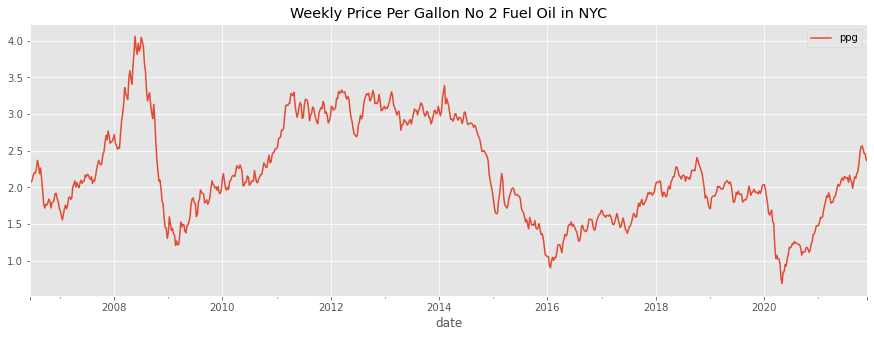

In [5]:
_=df.plot(figsize=(15,5),
          title = 'Weekly Price Per Gallon No 2 Fuel Oil in NYC')

## Decompose

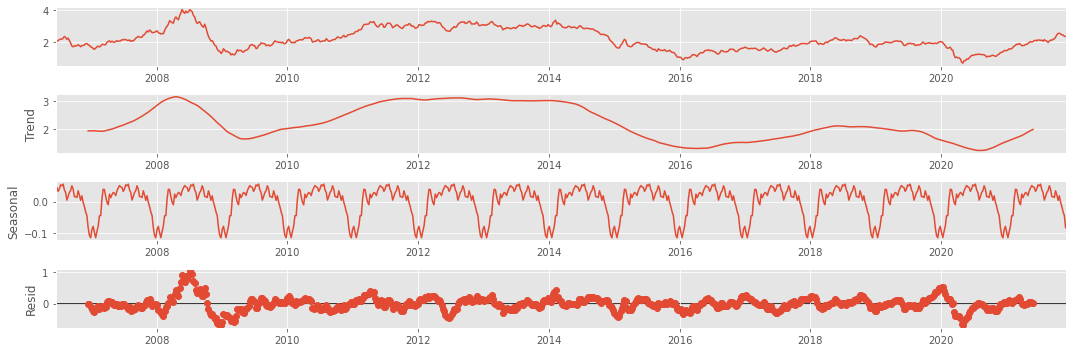

In [6]:
res = seasonal_decompose(df,model='add')
_=res.plot()

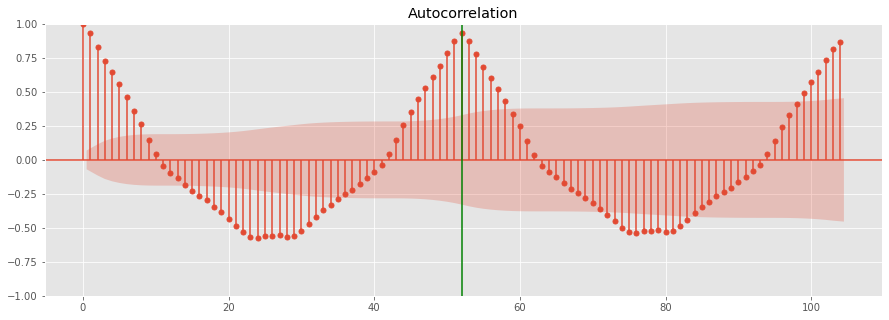

In [7]:
_=plot_acf(res.seasonal, lags=104)
_=plt.axvline(52,c='g')

## Estimate Parameters for ARIMA
No surprise seasonal portion is yearly...use auto arima for the others


## Test Train Split
Best model:  ARIMA(0,1,1)(0,0,0)[52]   


In [8]:
split_idx = int(len(df)*0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]
print(f'Training Set Size {len(train_df)}')
print(f'Test Set Size {len(test_df)}')

Training Set Size 645
Test Set Size 162


C:\Users\jfell\anaconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\jfell\anaconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                    ppg   No. Observations:                  645
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 759.322
Date:                Tue, 07 Dec 2021   AIC                          -1514.644
Time:                        18:57:06   BIC                          -1505.708
Sample:                    06-16-2006   HQIC                         -1511.177
                         - 10-19-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3044      0.030     10.241      0.000       0.246       0.363
sigma2         0.0055      0.000     22.630      0.000       0.005       0.006
Ljung-Box (L1) (Q):                   0.01   Jarque-

<AxesSubplot:xlabel='date'>

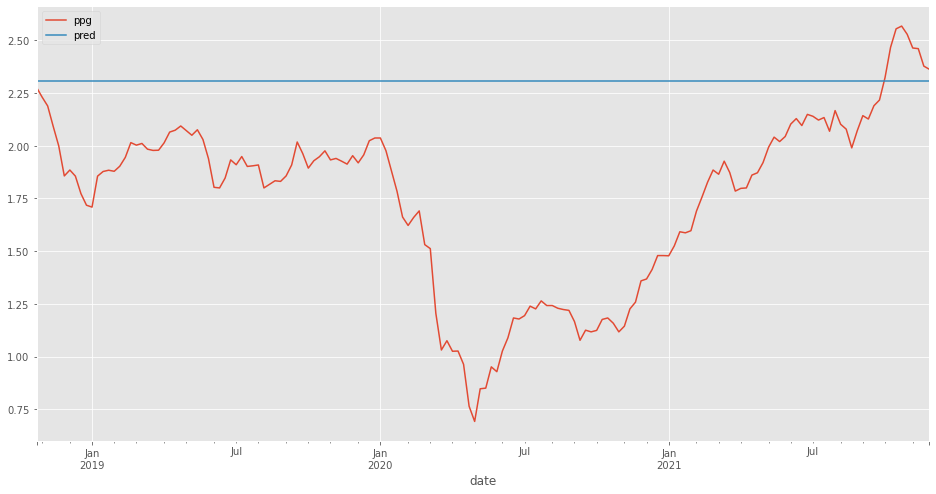

In [9]:
arima_model = SARIMAX(train_df, order=(0,1,1),
                     seasonal_order=(0,0,0,52))
res = arima_model.fit()
print(res.summary())
# Get Prediction
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end, 
                         typ='linear').rename('pred')
test_df.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

## Try Prophet

In [10]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

model = Prophet()

In [14]:
ptrain_df = train_df.reset_index().rename(columns={'date':'ds','ppg':'y'})
model.fit(ptrain_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
p_forcast = model.predict(model.predict(model.make_future_dataframe(periods=162,freq='W-FRI')))


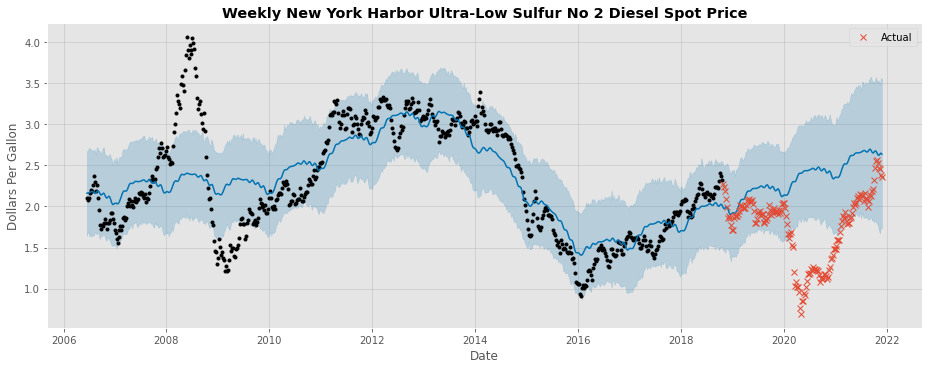

In [22]:
fig = model.plot(p_forcast,figsize=(13,5))
ax = fig.gca()
ax.plot(test_df.index,test_df.ppg,'x',label = 'Actual')
#ax.set_xlim(pd.to_datetime(['2008-01-01','2010-12-01']))
ax.legend(loc='best')
ax.set_title('Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price',
         fontweight='bold')
ax.set_ylabel('Dollars Per Gallon')
_=ax.set_xlabel('Date')